# fMRI prepreprocessing - Hands-on workshop

#### Max Planck School of Cognition, Methods in Cognitive Neuroscience, July 2022


##### Contacts: 
**Frauke Beyer** @ Neurology Dept., MPI CBS, Leipzig, Germany, fbeyer@cbs.mpg.de  
**Alexander Nitsch** @ Psychology Dept., MPI CBS, Leipzig, Germany, nitsch@cbs.mpg.de  
**Theo Schäfer** @ Psychology Dept., MPI CBS, Leipzig, Germany, tschaefer@cbs.mpg.de

Please contact us if you have any questions or problems with the notebook! Happy to help :)

### Objectives

Preprocessing of functional MRI data is an important step in analyzing both task-based and resting state fMRI studies.  
In this notebook, we will cover the main steps of fMRI preprocessing. You will
* learn how to plot and inspect fMRI data in python
* implement main preprocessing steps for fMRI data
* find out how to use `nipype` to embed different preprocessing steps

fMRI preprocessing can be performed by several software packages (e.g. SPM, FSL, AFNI) or standardized pipelines such as [fMRIPrep](https://fmriprep.org/en/stable/), [C-PAC](https://fcp-indi.github.io/docs/latest/user/quick.html) or [ABCD-Pipeline](https://github.com/DCAN-Labs/abcd-hcp-pipeline). The purpose of this tutorial is to familiarize yourself with each preprocessing step in detail so that you get a feeling of how these influence / transform the data. 

Additional useful resources on fMRI preprocessing / analysis:

- Lecture series: Principles of fMRI, including preprocessing [part 1](https://www.youtube.com/watch?v=Qc3rRaJWOc4&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=16) and [part 2](https://www.youtube.com/watch?v=qamRGWSC-6g&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=17)
- DartBrains Tutorial on fMRI analysis, including [preprocessing](https://dartbrains.org/content/Preprocessing.html)
- NI-edu by Lukas Snoek, tutorial on fMRI analysis, including [preprocessing](https://lukas-snoek.com/NI-edu/index.html)

### Packages

We will use one software package and different python packages in this hands-on session:
* <a href='fsl.fmrib.ox.ac.uk/'>FSL</a> is an open-source neuroimaging toolbox which is very common and extremely versatile. In FSL, you can do  task-based and resting state functional MRI analyses, as well as structural and diffusion MRI. You can find an overview of its functions and tutorials on the homepage. 

* [nipype](https://nipype.readthedocs.io/) is a Python project that provides a uniform interface to existing neuroimaging software and facilitates interaction between these packages within a single workflow. With Nipype you can integrate algorithms from different packages (e.g., ANTS, SPM, FSL, FreeSurfer, Camino, MRtrix, MNE, AFNI, Slicer, DIPY), into a single workflow which has many advantages in terms of flexibility, run time, reproducibility... 

* [nibabel](https://nipy.org/nibabel/) is a Python project which enables the handling of NIFTI-files, the most common format for MRI data, in python

* [nilearn](https://nilearn.github.io/) is a package for fast and easy statistical learning and plotting for NeuroImaging data.


### Data
In the hands-on sessions, we will primarily use functional and T1-weighted MRI data from `sub-160563d` located in `./fMRI_data`. The subject participated in the LIFE-Upgrade study at the MPI CBS and agreed on sharing his/her data. 
The other dataset in the folder `subj-010088` comes from the [LEMON Study](https://www.nature.com/articles/sdata2018308), a public dataset collected at the MPI CBS. You can also try out the analysis steps with this subject if you like.
Both MRI datasets are included in the repository, and you automatically have them in the `fMRI_data` folder. 

### Packages
#### FSL
[FSL](https://www.fmrib.ox.ac.uk/fsl) is a neuroimaging software package which includes many functions useful for preprocessing and analysis of fMRI.  
It has been installed for us on the jupyter-hub in a public folder. We have to add the path of the FSL binaries to our environment path and set the FSL directory. This step has to be performed every time we use the notebook.

In [1]:
import os
import getpass

# set FSL paths
os.environ["PATH"] += os.pathsep + "/home/" + getpass.getuser() + "/public/0579223/MCNcourse2022/fsl/bin"
os.environ["FSLDIR"] = "/home/" + getpass.getuser() + "/public/0579223/MCNcourse2022/fsl/"
os.environ["FSLOUTPUTTYPE"]="NIFTI_GZ"

To run commands in the shell from your notebook, use a "!" in front of the command.

In [2]:
# Test whether your FSL installation worked by typing
!echo $FSLDIR # should give you the location of your installation
!mcflirt # should return description of the function

/home/jovyan/public/0579223/MCNcourse2022/fsl/
Usage: mcflirt -in <infile> [options]

  Available options are:
        -out, -o <outfile>               (default is infile_mcf)
        -cost {mutualinfo,woods,corratio,normcorr,normmi,leastsquares}        (default is normcorr)
        -bins <number of histogram bins>   (default is 256)
        -dof  <number of transform dofs>   (default is 6)
        -refvol <number of reference volume> (default is no_vols/2)- registers to (n+1)th volume in series
        -reffile, -r <filename>            use a separate 3d image file as the target for registration (overrides refvol option)
        -scaling <num>                             (6.0 is default)
        -smooth <num>                      (1.0 is default - controls smoothing in cost function)
        -rotation <num>                    specify scaling factor for rotation optimization tolerances
        -verbose <num>                     (0 is least and default)
        -stages <number of search

### Packages
#### python-based packages
Now, we install `nipype 1.6.0`, `nibabel 2.5.2`, `nilearn 0.8.0`, `nipy 0.5.0`, `nitime 0.9` and `joblib 1.0.1` via `!pip install --user ...`. Again, we perform the installation with the ! directly from our notebook. 
The installation has to be done only once (so if you installed the packages during the EEG tutorial, you do not need to re-install them). Loading the packages has to be performed everytime you use the notebook.

In [3]:
!pip install --user nipype==1.6.0
!pip install --user nibabel
!pip install -U --user nilearn==0.8.0
!pip install -U --user joblib==1.0.1
!pip install --user nitime==0.9
!pip install nipy==0.5.0

  Using cached nipy-0.5.0-cp39-cp39-manylinux1_x86_64.whl (2.3 MB)


Now we import these packages, along with numpy and scipy and check their versions.

In [2]:
# in case packages can't be loaded
#os.environ["PATH"] += "/home/jovyan/.local/lib/python3.9/site-packages/"

import nipype
print("nipype version %s" %nipype.__version__)
import nibabel as nib
print("nibabel version %s" %nib.__version__)
import nilearn as nil
print("nilearn version %s" %nil.__version__)

220719-09:59:17,659 nipype.utils WARNING:
	 A newer version (1.8.3) of nipy/nipype is available. You are using 1.6.0
nipype version 1.6.0
nibabel version 4.0.1
nilearn version 0.8.0


In [3]:
import numpy as np
print("numpy version %s" %np.__version__)
import scipy
print("scipy version %s" %scipy.__version__)

numpy version 1.21.6
scipy version 1.8.0


Let's set the paths to the data. 

In [4]:
# Paths to functional and anatomical directories
dir_func = "/home/" + getpass.getuser() + "/soc_coding_tutorials/fMRI_data/sub-160563d/func/"
dir_anat = "/home/" + getpass.getuser() + "/soc_coding_tutorials/fMRI_data/sub-160563d/anat/"

# Path to functional image
func = dir_func + "sub-160563d_task-rest_bold.nii.gz"

# other subject
#func = "/home/" + getpass.getuser() + "/soc_coding_tutorials/fMRI_data/sub-010088/sub-010088_ses-01_task-rest_acq-AP_run-01_bold.nii.gz"

### Plotting
First, we load the `matplotlib` package.

In [5]:
import matplotlib.pyplot as plt

In order to be able to run interactive matplotlib plots in jupyter hub, we have to set the backend of the matplotlib package to notebook. This can be achieved by `%matplotlib notebook`.  
Note: If you are running the notebook on your local machine, the backend tk is prefered. You can set it by `%matplotlib tk`.  
In order to go back to inline plotting, you can write `%matplotlib inline`.

For more tips & tricks on how to best plot interactively in jupyter notebooks, [this](https://medium.com/@1522933668924/using-matplotlib-in-jupyter-notebooks-comparing-methods-and-some-tips-python-c38e85b40ba1) page  is quite helpful.

In [6]:
%matplotlib inline

### Loading the data
To load the data, we use nibabel's `load` function. This function converts the data from the [NIFTI-format]() into a `Nifti1Image` python object.   

A nibabel `Nifti1Image` object is the association of three things:  
* an numpy N-D array containing the image data;
* a (4, 4) affine matrix which specifies the orientation of the image
* image metadata in the form of a header.

Many functions from python neuroimaging packages such as `nilearn` and `nipy` directly operate on the `Nifti1Image`. Yet, you can also extract the `numpy` array from the object and directly modify this array.   



The affine matrix of the nibabel `Nifti1Image` maps the numpy-array to the anatomical or patient coordinate system. This coordinate system is orthogonal and oriented along the main axes of the participant. In a RAS+ coordinate system, the X (or first dimension of the numpy array) describes the **r**ight->left axis, Y refers to **a**nterior-> posterior, and Z **s**uperior-inferior. For more information on imaging coordinate systems, please see [here](https://www.slicer.org/wiki/Coordinate_systems).

Now we load the nifti of the functional scan into a nibabel image object:

In [7]:
img_func = nib.load(func)

# alternatively with nilearn
#img_func = nilearn.image.load_img(func)

#### Exercise 1
Find out about the image dimensions and total duration of this scan. You can use the built-in methods
(or functions) of the nibabel image-object `.shape` and `.header` described [here](https://nipy.org/nibabel/gettingstarted.html) and the nibabel methods for reading the image header [here](https://nipy.org/nibabel/nibabel_images.html). Advanced: Where would you find the TR (2s)?

In [15]:
print(img_func.shape)
print(img_func.header)
print(img_func.header.get_zooms()) # get voxel dimensions and TR

(64, 64, 30, 300)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 57
dim             : [  4  64  64  30 300   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  3.  3.  5.  2.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : alternating increasing 2
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=30;Time=125248.220;phase=1'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.9862856
quatern_d       : 0.16504762
qoffset_x       : 97.19415
qoffset_

### Visualization
Visualizing the data is always very helpful to get a feeling for the data and notice mistakes. As you saw in the exercise above, the fMRI data has several hundred volumes, i.e. imaging timepoints. This means we can either go through volumes over time, display one out of these volumes, or show the mean image.   
Going through the fMRI data over time is most easily done in 3D visualization software such as `fsleyes`, `mricron` or `freeview`.  
Unfortunately, these visualization tools cannot be used in the jupyter notebook. Instead, we can use `nilearn` to view the brain images or simple `matplotlib` plotting commands to scroll through the images interactively. 


#### Use nilearn to plot the mean image

In [17]:
# Let's calculate the mean image
# We do this by taking the mean along the 4th dimension (time)
from nilearn.image.image import mean_img
mean_func = mean_img(func)
mean_func.to_filename('./fMRI_data/sub-160563d/func/mean_func_raw.nii.gz')

/home/jovyan/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


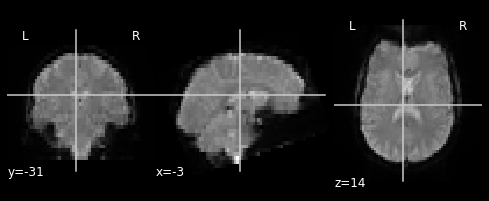

In [18]:
# Visualization of the fMRI in orthogonal slices (with nilearn)
from nilearn.plotting import plot_epi
plot_epi(mean_func, cmap="gray")

#### Use matplotlib to plot any slice of the 4D image array

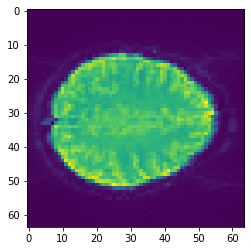

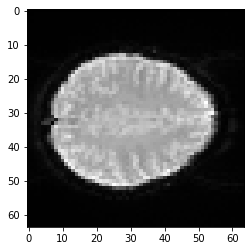

In [20]:
# Visualization of the fMRI (with numpy array & matplotlib)

# get image data
img_func_data = img_func.get_fdata()

# We have to select 2 dimensions from the 4D data set to be able to plot it in 2D with imshow.

# With this command, we plot the 21st axial slice of the second timepoint!!!
# Remember that python starts to enumerate from 0!
plt.imshow(img_func_data[:,:,20,1])
plt.show()

# with gray colormap this looks more like a brain: 
plt.imshow(img_func_data[:,:,20,1], cmap='gray')
plt.show()

#### Use a function to interactively plot the 4D fMRI data

We can use the package `ipywidgets` to create sliders which allow us to interactively modify a function. Here, we first define the function `plot_slice` to plot a single slice of the image (in the z, so inferior/superior, direction and at a single timepoint). Then, we create a second function `z_vol_viewer` in which we can interactively modify the slice and the timepoint with a slider.

In [58]:
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

def plot_slice(volume,z,vol):
    plt.imshow(volume[:,:,z,vol].T, cmap="gray")
    plt.show()

def z_vol_viewer(img):
    interact(plot_slice, volume=fixed(img), 
             z = widgets.IntSlider(value=img.shape[2]//2,
                                   min=0,
                                   max=img.shape[2]-1,
                                   step=1,
                                   description="z-axis"),
             vol = widgets.IntSlider(value=0,
                                     min=0,
                                     max=img.shape[3]-1,
                                     step=1,
                                     description="volume"),
            )

z_vol_viewer(img_func_data)

interactive(children=(IntSlider(value=15, description='z-axis', max=29), IntSlider(value=0, description='volum…

### Exercise 2 
If you feel like it, you can try to create a truely 3D/4D viewer by copying and then extending the function `z_vol_viewer` above.

In [64]:
def plot_slice(volume,axis,slicenum,vol):
    if axis=='x':
        plt.imshow(volume[slicenum,:,:,vol].T, cmap="gray", origin="lower")
    elif axis=='y':
        plt.imshow(volume[:,slicenum,:,vol].T, cmap="gray", origin="lower")
    elif axis=='z':
        plt.imshow(volume[:,:,slicenum,vol].T, cmap="gray", origin="lower")
    plt.show()

def vol_viewer(img, axis):
    
    if axis=='x': ax=0
    elif axis=='y': ax=1
    elif axis=='z': ax=2
    
    interact(plot_slice, axis=fixed(axis), volume=fixed(img), 
             slicenum = widgets.IntSlider(value=img.shape[ax]//2,
                                   min=0,
                                   max=img.shape[ax]-1,
                                   step=1,
                                   description="slice"),
             vol = widgets.IntSlider(value=0,
                                     min=0,
                                     max=img.shape[3]-1,
                                     step=1,
                                     description="volume"),
            )

vol_viewer(img_func_data, 'x')

interactive(children=(IntSlider(value=32, description='slice', max=63), IntSlider(value=0, description='volume…

Now let's inspect the time dimension of the fMRI data. To do so, we will plot the raw time series of two voxels (selected from the "middle" of the brain based on the plots above) by subsetting the `img_func_data` Numpy array. Try to play around with the voxel locations and compare the signal intensity and time courses.

Text(0, 0.5, 'Intensity')

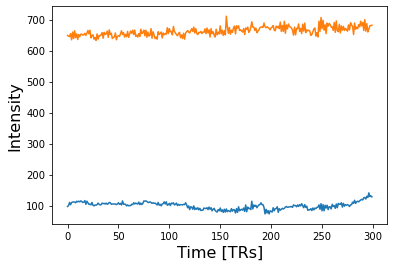

In [36]:
plt.plot(img_func_data[32,58,15, :])
plt.plot(img_func_data[24,30,10, :])

# plot multiple x locations from list
#[plt.plot(img_func_data[x,58,15, :]) for x in [22, 24, 32, 50]]

plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)

## Preprocessing   
Now that we have inspected our data, we can start preprocessing it. This means we prepare the data to be statistically analyzed by removing confounds and error variance.

fMRI preprocessing involves many steps, and research groups tend to do it "their own way" - by using specific software packages and algorithms, leaving out certain steps or choosing different parameters. This contributes to the relatively low reproducibility of neuroimaging research (see [Nature paper](https://www.nature.com/articles/s41586-020-2314-9) on the [NARPS](https://www.narps.info/) project). 
Here, we would like to show you the "core" preprocessing steps that are largely agreed upon in the community (and implemented in [fMRIprep](https://www.nature.com/articles/s41592-018-0235-4?proof=trueIn), a project aiming to standardize fMRI preprocessing).

### Preprocessing steps
1. realignment of volumes to reference volume and extraction of motion parameters
2. skull stripping
- *slice time correction (used only for high TR and single-band acquisition)*
- *susceptibility distortion correction (recommended but not covered here)*
3. Spatial normalization
4. Denoising (removal of physiological and head motion-related noise)
5. Temporal filtering (removal of linear trend)
6. Smoothing 

### Integration of different software packages with nipype
To perform the preprocessing steps, we have a large variety of neuroimaging software packages (FSL, Freesurfer, AFNI, SPM, nipy, ANTS ...) at our disposal. However, combining software from different packages in a clever and reproducible way is a big challenge.   
Here, `nipype` comes very handy: this python package provides a uniform interface to existing neuroimaging software and allows us to efficiently combine different software packages, dedicated python packages and our own functions. At first, it may seem a bit unintuitive to work with this 'overlay', yet, later it makes your life much easier by offering structure, adaptibility and scalability. Another advantage of learning `nipype` is that `fmriprep` and other recent software developments for reproducible neuroscience relie on its concepts. 

**nipype in a nutshell**  
[workflows](https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html) are the main feature of `nipype`. Workflows allow the intergration of different functions (from neuroimaging toolboxes or self-written) and the efficient computational execution of complex pipelines.  
[nodes](https://miykael.github.io/nipype_tutorial/notebooks/basic_nodes.html) are the building blocks of workflows and objects which execute a certain function. This function can be anything from a Nipype interface (wrapping an external algorithm) to a user-specified function or an external script.   
[interfaces](https://miykael.github.io/nipype_tutorial/notebooks/basic_interfaces.html) wrap a single command from various external packages (e.g. FSL, SPM or FreeSurfer), even if they themselves are written in another programming language than python. 
In the following, you will get to know the some of these concepts, but for a more complete introduction and explanation, please see the links to the great tutorials by [mykael](https://miykael.github.io/nipype_tutorial/).

![picture](https://miykael.github.io/nipype-beginner-s-guide/_images/architecture.png)

## 1. Realignment 
During the fMRI scan, participants frequently move their heads. This head motion can either be a slight drift, i.e. lowering the chin to the chest, or single abrupt head movements, for example when the subject awakes from a brief nap. Look at the motion in the image below.

![picture](https://miykael.github.io/nipype-beginner-s-guide/_images/movement.gif)

Therefore, the first preprocessing step is the realignment or motion correction of the scan. This operation aims to coregister all functional volumes to a common reference (oftentimes the first or middle volume), thereby aligning each voxel with itself over time. 
Here, we use the `MCFLIRT` [program](https://nipype.readthedocs.io/en/1.5.0/api/generated/nipype.interfaces.fsl.preprocess.html#mcflirt) from FSL for motion correction.  
First, we execute this command directly with `bash` (this can take a few minutes).

In [38]:
# Use bash to run MCFLIRT (specify in- & output)
!mcflirt -in ./fMRI_data/sub-160563d/func/sub-160563d_task-rest_bold.nii.gz -out ./fMRI_data/sub-160563d/func/sub-160563d_task-rest_bold_mcf.nii.gz -plots

#### Exercise 3: which volume is used as reference volume by MCFLIRT and how can you change this parameter?
Hint: Check the manual of the command MCFLIRT

In [39]:
!mcflirt

Usage: mcflirt -in <infile> [options]

  Available options are:
        -out, -o <outfile>               (default is infile_mcf)
        -cost {mutualinfo,woods,corratio,normcorr,normmi,leastsquares}        (default is normcorr)
        -bins <number of histogram bins>   (default is 256)
        -dof  <number of transform dofs>   (default is 6)
        -refvol <number of reference volume> (default is no_vols/2)- registers to (n+1)th volume in series
        -reffile, -r <filename>            use a separate 3d image file as the target for registration (overrides refvol option)
        -scaling <num>                             (6.0 is default)
        -smooth <num>                      (1.0 is default - controls smoothing in cost function)
        -rotation <num>                    specify scaling factor for rotation optimization tolerances
        -verbose <num>                     (0 is least and default)
        -stages <number of search levels>  (default is 3 - specify 4 for final s

Now, we will use  `nipype` to wrap the command in an interface. First, we load the interface for FSL from `nipype.interfaces.fsl`. 

In [11]:
# Load nipype interface for FSL
import nipype.interfaces.fsl as fsl
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

Then, we define the input (`inputs.in_file`) and options (`save_plots=True`) for the interface.   
We can see the commandline which is executed with the command `run` by printing `mcflrt.cmdline`. We see that it is essentially the same command as we wrote in bash before. 
The result ist saved in a python results-object, and can be assessed via `outputs`.

In [44]:
#Run spatial realignment 
mcflirt = fsl.MCFLIRT(save_plots=True) #define the interface and tell it to save plots
mcflirt.inputs.in_file = func #define input to the interface
mcflirt.inputs.out_file = './fMRI_data/sub-160563d/func/mcflirt.nii.gz'
print(mcflirt.cmdline) #show the commandline which is created by this interface
mcflirt_res = mcflirt.run() #run the interface, i.e. command line
par_file = mcflirt_res.outputs.par_file #extract the parameter file from the result object

mcflirt -in /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/sub-160563d_task-rest_bold.nii.gz -out fMRI_data/sub-160563d/func/mcflirt.nii.gz -plots


In [45]:
print(mcflirt_res.outputs) #show the outputs of this node


mat_file = <undefined>
mean_img = <undefined>
out_file = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/mcflirt.nii.gz
par_file = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/mcflirt.nii.gz.par
rms_files = <undefined>
std_img = <undefined>
variance_img = <undefined>



##### A Comment
<font color='gray'>

If you have completed the larger preprocessing steps once (and the outputs are located in `/fMRI_data/sub-160563d/func`), you don't have to run these steps again and instead refer to the full paths of the outputs in the upcomping preprocessing steps. 

In [69]:
# assess motion pre & post

mc_img = nib.load(mcflirt.inputs.out_file).get_fdata()

vol_viewer(mc_img, 'z')
#z_vol_viewer(mc_img)

vol_viewer(img_func_data, 'z')


interactive(children=(IntSlider(value=15, description='slice', max=29), IntSlider(value=0, description='volume…

interactive(children=(IntSlider(value=15, description='slice', max=29), IntSlider(value=0, description='volume…

## 2. Skull stripping

Until now, our fMRI data still includes skull and neck areas. For further processing, we would like to extract the signal coming exclusively from the brain. Therefore, we have to perform skull stripping and create a brain mask. To perform skull stripping, we need a reference image. Here, we take the mean image of the motion corrected fMRI data as reference image.    

### Create the mean image of motion corrected fMRI data
To calculate the mean of the motion corrected fMRI data, we could do it as above and re-use the nilearn function `mean_img`. But we would like to get into `nipype` and so we employ a `FSL` tool wrapped in `nipype`.   
The interface `ImageMaths` wraps the FSL command `fslmaths`, a versatile tool to perform voxel-wise calculations. The option `Tmean` calculates the 4D mean of the fMRI data.  
Below, we define the interface and define its input (`in_file`), output name (`out_file`) and the `Tmean` option. 

In [46]:
# Calculate mean motion corrected fMRI
mean_mcflirt_interface = fsl.ImageMaths(in_file = "./fMRI_data/sub-160563d/func/mcflirt.nii.gz", #mcflrt_res.outputs.out_file, #use output of previous interface as input
                                        out_file = "./fMRI_data/sub-160563d/func/mcflirt_mean_interface.nii.gz",
                                        op_string = '-Tmean')
res_mean_mcflirt_interface = mean_mcflirt_interface.run()

# or with nilearn
#mean_mcflirt_nilearn = mean_img("./fMRI_data/sub-160563d/func/mcflirt.nii.gz")

The same command can be wrapped with a Nipype `node`. This is an extension of the interface concept, making it possible to combine more operations in a workflow. 

In [12]:
# Import the Node module
from nipype import Node

# Create Node
mean_mcflirt_node = Node(fsl.ImageMaths(), name='mean_mcflirt_node')
mean_mcflirt_node.inputs.in_file = dir_func + 'mcflirt.nii.gz'
mean_mcflirt_node.inputs.out_file = dir_func + 'mcflirt_mean_node.nii.gz'
mean_mcflirt_node.inputs.op_string = "-Tmean"
res_mean_mcflirt_node = mean_mcflirt_node.run()

220719-10:26:26,15 nipype.workflow INFO:
	 [Node] Setting-up "mean_mcflirt_node" in "/tmp/tmp753nx1ce/mean_mcflirt_node".
220719-10:26:26,21 nipype.workflow INFO:
	 [Node] Running "mean_mcflirt_node" ("nipype.interfaces.fsl.utils.ImageMaths"), a CommandLine Interface with command:
fslmaths /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/mcflirt.nii.gz -Tmean /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/mcflirt_mean_node.nii.gz
220719-10:26:29,234 nipype.workflow INFO:
	 [Node] Finished "mean_mcflirt_node".


We can plot the two (identical) results using `plot_epi`:

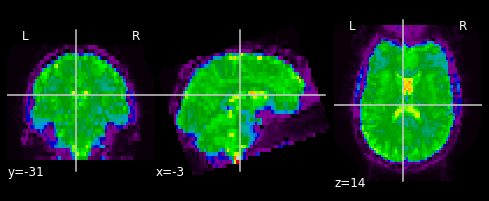

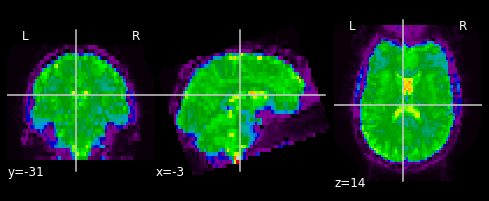

In [49]:
#if you ran the commands above:
plot_epi(res_mean_mcflirt_interface.outputs.out_file)
plot_epi(res_mean_mcflirt_node.outputs.out_file)

#if you ran the commands before and have pre-computed data:
#plot_epi("./fMRI_data/sub-160563d/func/mcflirt_mean_interface.nii.gz")
#plot_epi("./fMRI_data/sub-160563d/func/mcflirt_mean_node.nii.gz")

### Perform the skull stripping

Skull stripping can be achieved with the function BET in FSL, wrapped in [nipype](https://nipype.readthedocs.io/en/1.5.0/api/generated/nipype.interfaces.fsl.preprocess.html#bet) 

In [50]:
bet = fsl.BET(mask=True)
bet.inputs.in_file = "./fMRI_data/sub-160563d/func/mcflirt_mean_node.nii.gz"  # res_mean.outputs.out_file
bet.inputs.out_file = "./fMRI_data/sub-160563d/func/mcflirt_mean_brain.nii.gz"
bet_res = bet.run()

In [51]:
print(bet_res.outputs)


inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/mcflirt_mean_brain_mask.nii.gz
meshfile = <undefined>
out_file = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/mcflirt_mean_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_file = <undefined>
skull_mask_file = <undefined>



Alternatively, we can use the `compute_epi_mask` function in nilearn.

In [86]:
from nilearn.masking import compute_epi_mask
mask_img = compute_epi_mask(func)

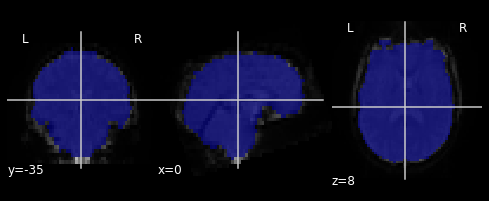

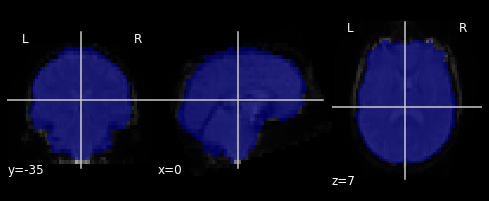

In [53]:
# Plot the brain mask overlaid with the functional image
from nilearn.plotting import plot_roi
plot_roi(mask_img, res_mean_mcflirt_interface.outputs.out_file)
plot_roi(bet_res.outputs.mask_file, res_mean_mcflirt_interface.outputs.out_file)

The mask created with BET looks slightly better as it does not exclude so many voxels in the medial OFC. On the other hand, it seems to include skull in some parts of the brain (e.g. near visual cortex).

## 3. Spatial normalization

We would like to bring all functional images into the same reference space to compare task-based activations or resting state ongoing activity. Usually, we do this by registering the functional and anatomical images of the same individual, aligning the individual anatomical images to a common template and then applying both operations to the fMRI scan. See the figure below for the three-step procedure:
!["Registration"](registration_steps.png)
As discussed in the lecture, there are some drawbacks of this method (e.g. participants may have very different anatomy or may differ in where activation occurs), yet it is still the standard in fMRI research.  

Often, the MNI space is chosen as template space. Here, different versions of template are available, depending on the number and kinds of averages, and whether the template was constructed to be symmetric or asymmetric. See the [MNI ICBM page](http://nist.mni.mcgill.ca/?p=904) for a more detailed description of the available templates and the [fmriprep documentation](https://fmriprep.org/en/20.1.1/spaces.html?highlight=mni#standard-spaces) for all templates available in `fmriprep`.

### Anatomical Data

When we do a fMRI Study, we always acquire a T1-weighted anatomical sequence along with the functional scans. The T1-weighting of these images provides a good grey matter-white matter contrast and depiction of the anatomy in these images.

We use the anatomical data to 
1. spatially coregister the functional scans of our study partipants together - due to the low contrast and anatomical detail, we cannot directly use the functional scan for it. 
2. specify regions of interest for functional imaging analysis (seed-based connectivity or regions of interest for activation studies) and denoising

Common T1-weighted sequences are MPRAGE (Magnetization Prepared Rapid Gradient Echo) on Siemens or 3D TFE (Turbo Field Echo) on Philips scanners. 
The anatomical data (`T1w` from a MPRAGE sequence) is located in the `anat_MRI` folder in the `soc_coding_tutorials` repository.   

In [71]:
# path to anatomical image
T1w = dir_anat + "sub-160563d_T1w.nii.gz"

Let's have a look at the T1W image. We can use the special nilearn function `plot_anat`.

/home/jovyan/.local/lib/python3.9/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


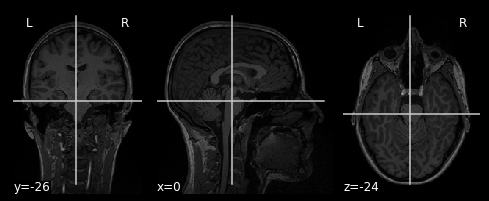

In [72]:
from nilearn import plotting
plotting.plot_anat(T1w)

### 3.1 Co-registration of functional scan to structural T1w scan
Before we perform the co-registration of functional and anatomical scan, we remove the skull and other non-brain tissue from the anatomical scan to achieve a better result.
Like for the functional imaging, we can use `BET` to perform skull-stripping.   


#### Brain extraction

Extract the brain from the T1w image with `BET`.

In [73]:
bet_T1w = fsl.BET(mask=True)
bet_T1w.inputs.in_file = T1w
bet_T1w.inputs.out_file = dir_anat + "T1w_brain.nii.gz"
res = bet_T1w.run()

Take a look at the brain mask and check whether it is correct

/home/jovyan/.local/lib/python3.9/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


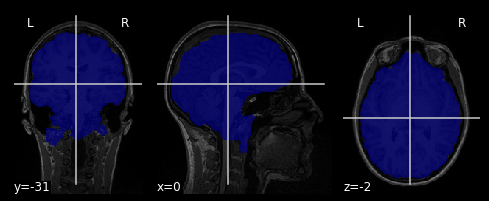

In [74]:
from nilearn.plotting import plot_roi
plot_roi(res.outputs.mask_file, T1w)

Brain extraction did not work perfectly. We see that a part of the neck and brainstem area is still included. We can give `BET` the coordinates of (roughly) the center of gravity (i.e. the middle of the brain) to improve estimation

In [75]:
bet_T1w = fsl.BET(mask=True)
bet_T1w.inputs.in_file = T1w
bet_T1w.inputs.center = [86,106,180] 
bet_T1w.inputs.out_file = dir_anat + "T1w_brain_masked.nii.gz"
res = bet_T1w.run()

/home/jovyan/.local/lib/python3.9/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


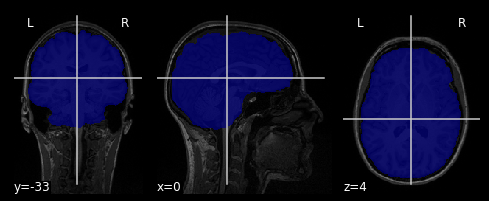

In [76]:
from nilearn.plotting import plot_roi
plot_roi(res.outputs.mask_file,T1w)

Now the brain mask looks fine!

We use this skull-stripped brain to perform the registration with the functional image. For this linear registration, we use FLIRT. If the field-of-view is large (i.e. whole-brain fMRI acquisition), and no calibration has been performed on your scanner (which may cause scaling differences between acquisitions), 6 degrees-of-freedom (i.e. 3 translations + 3 rotations) are appropriate. More answers to frequently asked questions around FLIRT, see [here](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FLIRT/FAQ).

Now, we will use  `nipype` to wrap the command in a Node. First, we load the interface for FSL from `nipype.interfaces.fsl`. 

In [81]:
linear_reg = Node(fsl.FLIRT(dof=6, cost_func='mutualinfo'), name='linear_reg')
linear_reg.inputs.in_file = dir_func + "mcflirt_mean_brain.nii.gz"
linear_reg.inputs.reference = dir_anat + "T1w_brain_masked.nii.gz"
linear_reg.inputs.out_file = dir_anat + "fmri_to_t1w.nii.gz"
linear_reg.inputs.out_matrix_file = dir_anat + "fmri_to_t1w.mat"
linear_reg_res=linear_reg.run()

220718-16:02:04,561 nipype.workflow INFO:
	 [Node] Setting-up "linear_reg" in "/tmp/tmplkgewr8b/linear_reg".
220718-16:02:04,569 nipype.workflow INFO:
	 [Node] Running "linear_reg" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/mcflirt_mean_brain.nii.gz -ref /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain_masked.nii.gz -out /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/fmri_to_t1w.nii.gz -omat /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/fmri_to_t1w.mat -searchcost mutualinfo -dof 6
220718-16:02:15,513 nipype.workflow INFO:
	 [Node] Finished "linear_reg".


Look at the result. Unfortunately, the visualization is not ideal in the notebook. If possibly, download these files and have a look at them in `FSLEYES` or `FREEVIEW`.

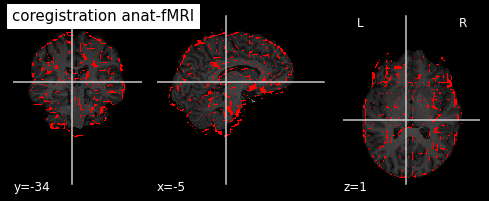

In [82]:
display = plotting.plot_anat(dir_anat + "T1w_brain_masked.nii.gz", title="coregistration anat-fMRI")
display.add_edges(dir_anat + "fmri_to_t1w.nii.gz")

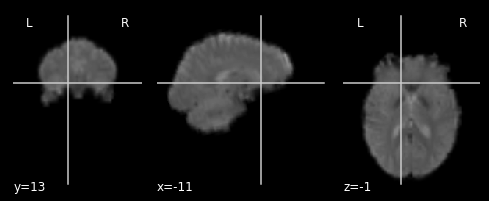

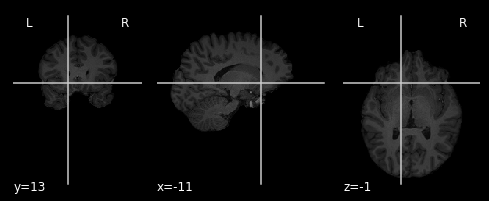

In [83]:
plotting.plot_anat(dir_anat + "fmri_to_t1w.nii.gz", cut_coords=[-11, 13, -1])
plotting.plot_anat(dir_anat + "T1w_brain_masked.nii.gz", cut_coords=[-11, 13, -1])

#### Exercise 1
Compare the result of the registration with the alignment of the images before the registration (using the same plotting logic as above).

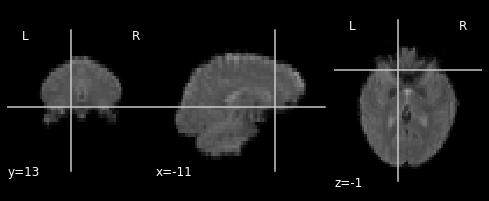

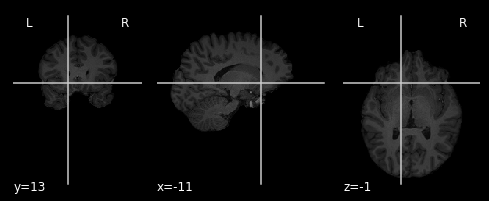

In [89]:
plotting.plot_anat(dir_func + "mcflirt_mean_brain.nii.gz", cut_coords=[-11, 13, -1])
plotting.plot_anat(dir_anat + "T1w_brain_masked.nii.gz", cut_coords=[-11, 13, -1])

### 3.2 Non-linear spatial registration of anatomical image and template 

Next, we perform the second step, the non-linear registration of anatomical image and reference template.   
First, we use `nilearn` to fetch the MNI ICBM 2009 template. We use the key `T1` to access the T1-weighted template.

In [90]:
from nilearn import datasets
icbm = datasets.fetch_icbm152_2009()
template_ICBM = icbm['t1']
template_ICBM_mask = icbm['mask']

apply_MNI_mask = fsl.ImageMaths()
apply_MNI_mask.inputs.in_file = template_ICBM
apply_MNI_mask.inputs.mask_file = template_ICBM_mask
apply_MNI_mask.inputs.out_file = "/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz"
apply_MNI_mask.run()


Dataset created in /home/jovyan/nilearn_data/icbm152_2009



Downloaded 43687936 of 63027871 bytes (69.3%,    0.9s remaining) ...done. (6 seconds, 0 min)
Extracting data from /home/jovyan/nilearn_data/icbm152_2009/e05b733c275cab0eec856067143c9dc9/download..... done.


Before we start with the non-linear registration, we perform a "pre" registration step where we rigidly align the T1w image and the MNI template. (You can try and see what happens if you omit this step :))
This step takes quite a while, so please be patient and wait. If you have run it once, you can specify the path to the result files in the following steps.

In [91]:
prereg = Node(fsl.FLIRT(dof=6, cost_func='mutualinfo'), name='prereg')
prereg.inputs.reference = "/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz"
prereg.inputs.in_file = dir_anat + "T1w_brain.nii.gz"
prereg.inputs.out_file = dir_anat + "t1w_2_mni_prereg.nii.gz"
prereg.inputs.out_matrix_file = dir_anat + "t1w_2_mni_premat.mat"
prereg_res=prereg.run()

220718-16:32:13,328 nipype.workflow INFO:
	 [Node] Setting-up "prereg" in "/tmp/tmptizdqvcq/prereg".
220718-16:32:13,333 nipype.workflow INFO:
	 [Node] Running "prereg" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain.nii.gz -ref /home/jovyan/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz -out /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni_prereg.nii.gz -omat /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni_premat.mat -searchcost mutualinfo -dof 6
220718-16:38:07,51 nipype.workflow INFO:
	 [Node] Finished "prereg".


Now, we give this pre-matrix to the non-linear registration function `FNIRT` to perform the non-linear registration of the anatomical image and the MNI space (i.e. changes in size and form of the brain). We use it with its default parameters (see [here](https://nipype.readthedocs.io/en/1.5.0/api/generated/nipype.interfaces.fsl.preprocess.html#fnirt)) in a `nipype` node. `FNIRT` estimates a warp field (i.e. a vector field which describes the displacement of each point). Therefore, it takes quite a long time to run (around 45 minutes on the jupyter hub), so please run it before our session.

In [16]:
import nipype.interfaces.fsl as fsl
from nipype.pipeline.engine import Node
import nipype.interfaces.utility as util

# initiate workflow
nonlinear_reg = Node(fsl.FNIRT(),
                name='nonlinear_reg')
nonlinear_reg.inputs.in_file = dir_anat + "T1w_brain.nii.gz"
nonlinear_reg.inputs.ref_file = "/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz"
nonlinear_reg.inputs.affine_file = dir_anat + "t1w_2_mni_premat.mat"
nonlinear_reg.inputs.warped_file = dir_anat + "t1w_2_mni.nii.gz"
nonlinear_reg.inputs.field_file = dir_anat + "t1w_2_mni_warpfield.nii.gz"
nonlinear_reg_res = nonlinear_reg.run()

210610-08:10:13,674 nipype.workflow INFO:
	 [Node] Setting-up "nonlinear_reg" in "/tmp/tmpa43c7wun/nonlinear_reg".
210610-08:10:13,686 nipype.workflow INFO:
	 [Node] Running "nonlinear_reg" ("nipype.interfaces.fsl.preprocess.FNIRT"), a CommandLine Interface with command:
fnirt --aff=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni_premat.mat --fout=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni_warpfield.nii.gz --in=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain.nii.gz --logout=/tmp/tmpa43c7wun/nonlinear_reg/T1w_brain_log.txt --ref=/home/jovyan/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz --iout=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni.nii.gz
210610-08:28:43,647 nipype.workflow INFO:
	 [Node] Finished "nonlinear_reg".


In [8]:
display = plotting.plot_anat("/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz", title="coregistration T1-MNI")
#display.add_edges()
display.add_overlay(dir_anat + "t1w_2_mni.nii.gz")

NameError: name 'plotting' is not defined

Remember: Our goal is to register our functional motion corrected mean image to the MNI space. Let's plot the functional motion corrected mean image again:

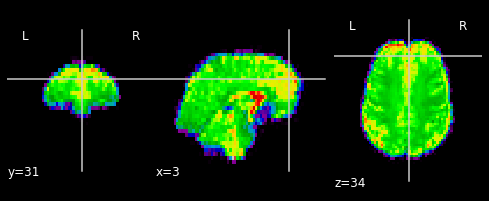

In [45]:
plotting.plot_epi(dir_func + "mcflirt_mean_brain.nii.gz")

Now, we combine both steps and transform our functional image into MNI space with the `ApplyWarp` interface. This function combines and applies different registration matrices and warps. As `premat`, we use the tranform from individual fMRI to anatomical space, and as warp file, we use the transform from anatomical to MNI space. Both transforms taken together yield the (mean) fMRI image in MNI space. It would take too long to transform the complete fMRI scan, therefore we use the mean image here.

In [54]:
reg_func2mni = fsl.ApplyWarp()
reg_func2mni.inputs.in_file = dir_func + "mcflirt_mean_brain.nii.gz"
reg_func2mni.inputs.ref_file = "/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz"
reg_func2mni.inputs.field_file = dir_anat + "t1w_2_mni_warpfield.nii.gz"
reg_func2mni.inputs.premat = dir_anat + "fmri_to_t1w.mat"
reg_func2mni.inputs.out_file = dir_func + "fmri_to_mni.nii.gz"
res = reg_func2mni.run() 

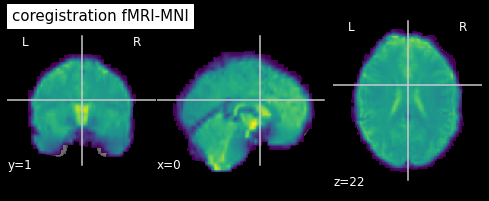

In [56]:
display = plotting.plot_anat("/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz", title="coregistration fMRI-MNI")
display.add_overlay(dir_func + "fmri_to_mni.nii.gz")

### 3.3 Tissue segmentation
For many approaches it is useful to have the data segmented into tissue types. As described in the aMRI lecture, SPM's `Dartel` or `New Segment` are common approaches to do so, which also allow to run voxel-based morphometry.   
But `FSL` also provides a tool to perform tissue segmentation. We try this for visualization purposes.

In [92]:
fast_seg = fsl.FAST()
fast_seg.inputs.in_files = dir_anat + "T1w_brain.nii.gz"
fast_seg.inputs.img_type = 1
print(fast_seg.cmdline)
fast_seg.run()

fast -t 1 -S 1 /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain.nii.gz


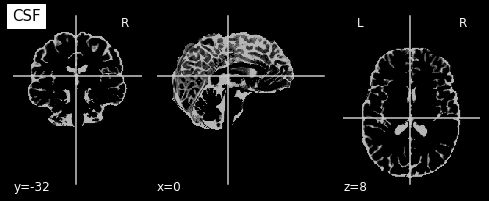

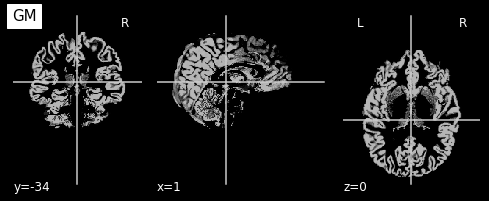

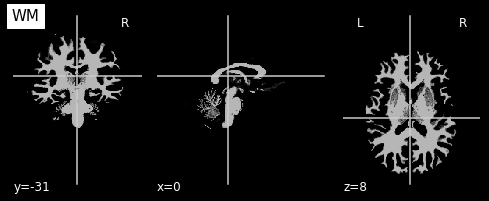

In [58]:
%matplotlib inline
from nilearn import plotting
display = plotting.plot_anat(dir_anat + "T1w_brain_pve_0.nii.gz", title="CSF")
display = plotting.plot_anat(dir_anat + "T1w_brain_pve_1.nii.gz", title="GM")
display = plotting.plot_anat(dir_anat + "T1w_brain_pve_2.nii.gz", title="WM")


## Interim summary

For now, we completed the fundamental preprocessing steps (removing non-brain signal and correcting for spatial distortions). There is probably still substantial noise in the data which we should deal with before the statistical analysis. Therefore, we will now take a look at denoising strategies.   

## 4. Removing noise confounds
Functional MRI signal can be confounded by different non-neuronal noise sources (including slow scanner drift, instrument noise, head motion, respiration, cardiac pulsation). 
For a detailed review of the possible sources of noise in the BOLD signal, please see [this publication](https://link.springer.com/article/10.1007%2Fs11336-012-9294-0).  
In task-based fMRI, the BOLD signal is evaluated in reference to an external stimulus, and thus is less susceptible to the effects of unstructured noise. Yet, noise confounds are usually added to the task regressors in the 1st-level analysis.
In resting state fMRI there is no external reference and therefore noise may introduce spurious correlations between brain regions. Here, the most important confounder is head motion, which can have both very pronounced effects (if a participant turns the head to a new position or markably shakes) and very subtle effects (microscopic head movements smaller than the size of a voxel).
There are different techniques which aim to reduce the impact of head motion and obtain a cleaner (rs)fMRI signal. 

Denoising can be grouped into:
- **Nuisance regression methods**: include noise as nuisance variables in a linear model (GLM) of the fMRI data to remove their influence (e.g. motion parameters, PCA noise components: [CompCor](https://www.sciencedirect.com/science/article/abs/pii/S1053811907003837), physiological measures)
- **Scrubbing methods**: discard disrupted volumes of the data, e.g. described [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3849338/).
- **ICA-based methods**: extract signal and noise components of the data and manually/automatically remove noise components ([ICA-AROMA](https://www.sciencedirect.com/science/article/abs/pii/S1053811915001822), [FIX-ICA](https://www.sciencedirect.com/science/article/abs/pii/S1053811914001815))

This [paper](https://www.sciencedirect.com/science/article/pii/S1053811917302288) provides a comparison of different strategies to mitigate head motion, and the same authors have published a [protocol](https://experiments.springernature.com/articles/10.1038/s41596-018-0065-y) with detailed instructions how to apply and control head motion correction techniques.
This [paper](https://www.sciencedirect.com/science/article/pii/S1053811917310972) also compares the performance of different preprocessing pipelines for resting state fMRI.


### 4.1 Visualization of noise confounds
First, we have a look at the motion parameters from `mcflirt`. These are three translational and three rotational measures, indicating how much the volume had to be rigidly translated and rotated compared to the reference.  First, we load the data from the `.par` parameter file using `pandas`. This [package]() is very handy for working with text or tabular files in python.

In [69]:
import pandas as pd
realign_params = dir_func + 'mcflirt.nii.gz.par'
rp = pd.read_csv(realign_params, header=None, sep='  ')
print(np.shape(rp))

(300, 6)


/tmp/ipykernel_66/7764105.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  rp = pd.read_csv(realign_params, header=None, sep='  ')


Now, let's plot the motion parameters (red is x, blue is y and green is z-direction).

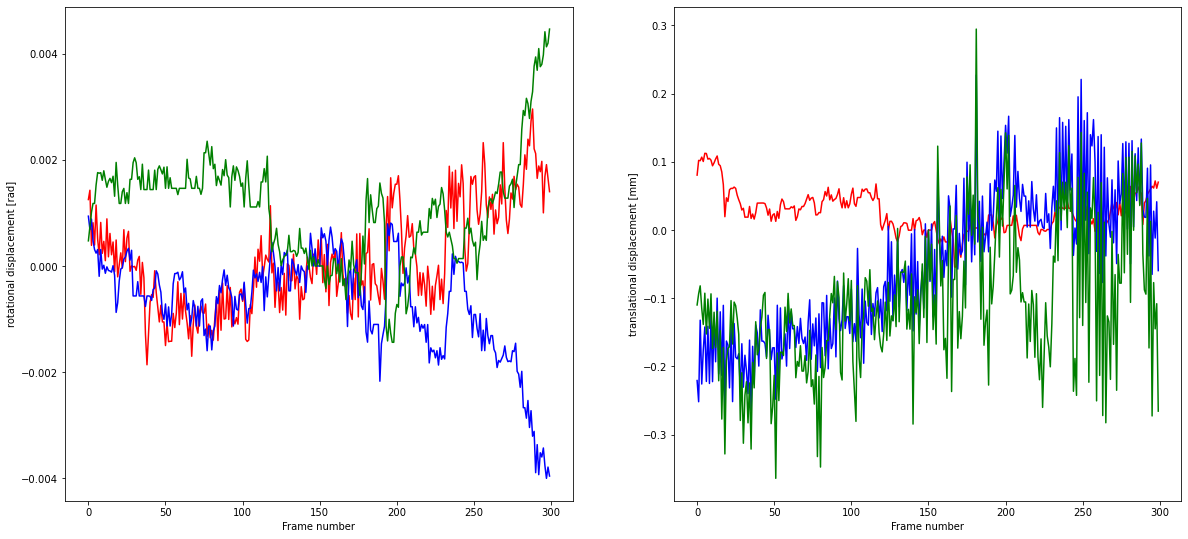

In [136]:
from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec

rp = np.array(rp).T

fig = Figure(figsize=(20,20))
grid = GridSpec(2, 2) 
ax = fig.add_subplot(grid[0:1,0])
ax.plot(rp[0, :], color="red")
ax.plot(rp[1, :], color="blue")
ax.plot(rp[2, :], color="green")
ax.set_ylabel("rotational displacement [rad]")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[0:1,1])
ax.plot(rp[3, :], color="red")
ax.plot(rp[4, :], color="blue")
ax.plot(rp[5, :], color="green")
ax.set_ylabel("translational displacement [mm]")
ax.set_xlabel("Frame number")
fig

From the rotational parameters, we see that the subject turned its head very subtly to the right throughout the scan (blue rotational parameters indicating rotation around y-axis called roll). This can be best seen when comparing early & late volumes.
From the translational parameters, we see that he/she performed up-down movements (green translational parameter indicating movement in the z-direction). There was little displacement in x-direction (red translational parameter), and some displacement in the y-direction in the first half of the scan (blue translational parameter).
We can summarize these motion parameters using Framewise displacement, a measure adding the total displacement from frame to frame. See the [original publication](https://pubmed.ncbi.nlm.nih.gov/22019881) for more details.

In [122]:
from nipype.algorithms.confounds import FramewiseDisplacement

FrameDisp = FramewiseDisplacement()
FrameDisp.inputs.in_file = realign_params
FrameDisp.inputs.out_file = dir_func + "power_fd.txt"
FrameDisp.inputs.parameter_source = "FSL"
res_FD = FrameDisp.run()

fd = pd.read_csv(FrameDisp.inputs.out_file)
print(fd)

     FramewiseDisplacement
0                 0.104257
1                 0.206534
2                 0.181753
3                 0.109244
4                 0.149965
..                     ...
294               0.515759
295               0.363521
296               0.154976
297               0.127371
298               0.302072

[299 rows x 1 columns]


In [118]:
print(res_FD.outputs)


fd_average = 0.21766871291973247
out_figure = <undefined>
out_file = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/power_fd.txt



We now compare the motion parameters to the global signal (GS). This is the average of all voxels intensities over time. We compute it with a `nilearn` function which masks the data and returns the masked data in a flat array. Then, we take the average of this array along the second dimension.

In [120]:
from nilearn.masking import apply_mask
import numpy as np

masked_data = apply_mask(dir_func + 'mcflirt.nii.gz', 
                         dir_func + 'mcflirt_mean_brain_mask.nii.gz')
GS = np.mean(masked_data,axis=1)

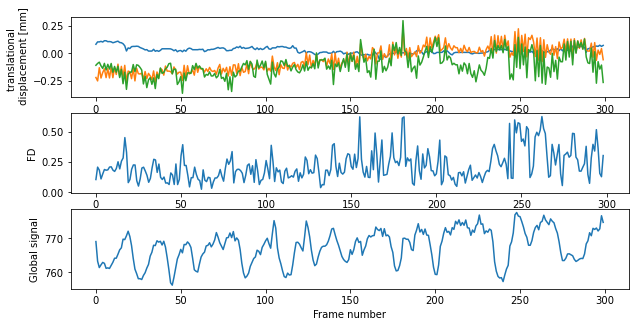

In [121]:
fig = Figure(figsize=(10,5))
grid = GridSpec(3,1) 
ax = fig.add_subplot(grid[0,0])
ax.plot(rp[3, :])
ax.plot(rp[4, :])
ax.plot(rp[5, :])
ax.set_ylabel("translational \n displacement [mm]")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[1,0])
ax.plot(fd)
ax.set_ylabel("FD")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[2,0])
ax.plot(GS)
ax.set_ylabel("Global signal")
ax.set_xlabel("Frame number")
fig

We see that there is a periodic variation in the global signal. Let's calculate its frequency! - skip it?

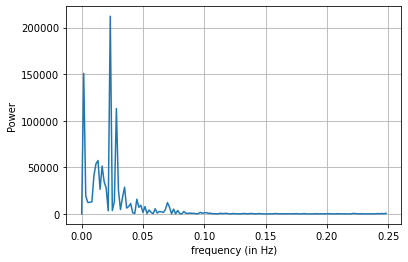

In [39]:
from scipy.fft import fft, fftfreq
# Number of sample points/volumes
N = 300
# sample spacing (repetition time)
T = 2.0 

x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(0.02 * 2.0*np.pi*x) + 0.8*np.sin(0.01 * 2.0*np.pi*x)
y = GS - np.mean(GS)

yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, np.abs(yf[0:N//2])**2)
plt.xlabel("frequency (in Hz)")
plt.ylabel("Power")
plt.grid()
plt.show()

The low-intensity frequencies in this fMRI timeseries fall in the frequency range of neuronal fluctuations (0.01 - 0.1 Hz). Yet, there may still be noise components inside (stemming from aliasing of higher-frequency signals (respiration & cardiac pulsation), sympathetic nervous system tone, partial pressure of carbon dioxide (paCO2) fluctuations modulated by respiration, blood pressure regulation, low frequency neuronal “waves,” and even gastric motility [Reference](https://www.frontiersin.org/articles/10.3389/fnins.2019.00787/full).) 

Another important diagnostic measure is the temporal derivative of the GS. DVARS is taking the temporal **D**erivative, then calculating the RMS **VAR**iance over element**S**. DVARS is informative about volumes with large signal intensity changes, e.g. due to motion or instrument artifact.  
It can be used to identify problematic volumes for later scrubbing or censoring (e.g. excluding the volumes for further analyses or using them as regressors on the first-level).   
The `ComputeDVARS` function returns both the unstandardized DVARS (scaled to 1000 leading to the units being expressed in x10 %ΔBOLD change) and standardized DVARS (normalized with the standard deviation of the temporal difference time series). For more information on which measure and criteria to apply to scrub volumes based on DVARS, please see [this publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5915574/). 

In [127]:
from nipype.algorithms.confounds import ComputeDVARS

computeDvars = ComputeDVARS()
computeDvars.inputs.in_file = dir_func + "mcflirt.nii.gz"
computeDvars.inputs.in_mask = dir_func + "mcflirt_mean_brain_mask.nii.gz"
res_DVARS = computeDvars.run() 

# move the output to the other preprocessing outputs
!mv mcflirt_dvars_std.tsv fMRI_data/sub-160563d/func

# to have DVARS as plottable object
dvars = pd.read_csv(dir_func + "mcflirt_dvars_std.tsv", header=None)
print(dvars)

/opt/conda/lib/python3.9/site-packages/numpy/lib/shape_base.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/opt/conda/lib/python3.9/site-packages/numpy/lib/shape_base.py:402: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


            0
0    1.104139
1    0.888405
2    1.022472
3    0.993907
4    0.964045
..        ...
294  1.882365
295  1.593328
296  1.476874
297  1.910645
298  2.157344

[299 rows x 1 columns]


Now, let's plot all metrics together

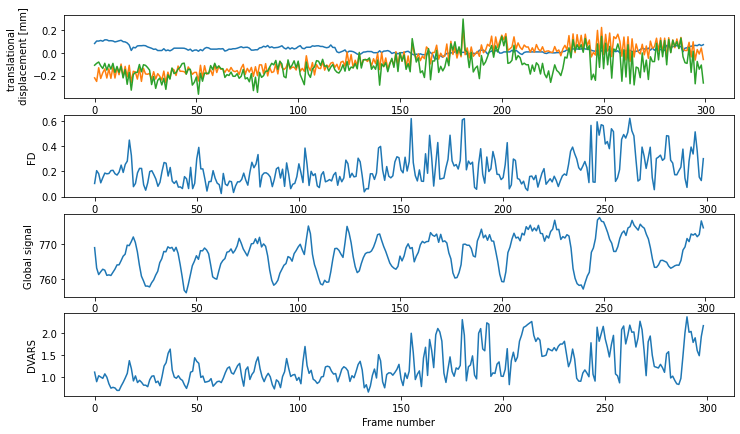

In [128]:
fig = Figure(figsize=(12,7))
grid = GridSpec(4,1) 
ax = fig.add_subplot(grid[0,0])
ax.plot(rp[3, :])
ax.plot(rp[4, :])
ax.plot(rp[5, :])
ax.set_ylabel("translational \n displacement [mm]")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[1,0])
ax.plot(fd)
ax.set_ylabel("FD")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[2,0])
ax.plot(GS)
ax.set_ylabel("Global signal")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[3,0])
ax.plot(dvars)
ax.set_ylabel("DVARS")
ax.set_xlabel("Frame number")
fig

We see that for some volumes (around frame 180, 250) FD and DVARS peaks coincide. Yet, the global signal does not seem particularly off. This difference is due to the fact that DVARS reflects *variability* of the temporal derivative over voxels, while the global signal is the mean of all voxels. Thus, it is possible that the intensity changes strongly in some voxels, but not at all or only slightly in the majority of all voxels.  
To further explore the appearance of confounds in the data, **carpet plots** are extremely valuable. They show the gray values of each voxel (or brain region) for each timepoint.

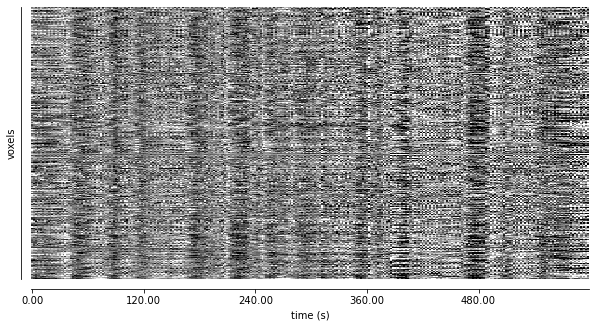

In [131]:
from nilearn.plotting import plot_carpet

plot_carpet(func, mask_img)
plt.show()

Here, we see that actually most voxels show dark bands. This speaks against the low-frequency fluctuations being of neuronal origin, as only GM voxels should show this pattern then. We also see that the global drop in signal around frame 240 (time 480s) is not really related to motion parameters, and may thus be caused by respiration, such as a deep inhale.

#### Small excursion about other carpet plots
[Carpet plots](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5296400/) combined with head motion parameters, DVARS and if available, physiological data (such as recordings from respiration belts or pulse oxiymetry) are a great tool to investigate confounders in your fMRI data. 
The carpet plot function is implemented in [fmriprep](https://fmriprep.readthedocs.io/en/stable/usage.html) and [mriqc](https://mriqc.readthedocs.io/en/latest/). See this presentation by [J. Power](https://www.pathlms.com/ohbm/courses/5158/sections/7788/video_presentations/75974), the inventor of *the plot*, on the interpretation.   
Below you see three examples from another study, where the carpet shows the signal from voxels in GM (red), WM (green), CSF (orange) & cerebellum (blue). 
![Example 1](summary_fmriplot_good_example.png)
![Example 2](summary_fmriplot_intermediate.png)
![Example 3](summary_fmriplot_bad_example.png)

More functions to calculate and plot FD and DVARS can be found in the file `motion.py`.

### 4.2 Nuisance regression
Including motion parameters (as well as their first and second derivatives) or physiological confounders into resting state and task-based fMRI analyses is commonly accepted. Yet, this is often not **sufficient** (especially for resting state fMRI) to remove unwanted variance. For more information, see these publications which compared different resting state preprocessing strategies by [Parkes](https://www.sciencedirect.com/science/article/pii/S1053811917310972) & [Ciric](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5483393/).  
GS regression is an effective way to perform motion correction (as described in the publications above). Yet, it also has the downside of introducing spurious, negative correlations, and introduces a distance-dependence in the connectivity between brain regions.See here for a [consensus statement](https://www.sciencedirect.com/science/article/pii/S1053811916306711) on the usage of GS regression.  
Let's create a node which performs a linear regression to remove the six motion parameters and GS from the rs fMRI. A node works in a working directory (`/tmp`), therefore we specify full paths to the input.

In [146]:
# Use 3 rotational and 3 translational motion parameter AND the global signal as regressors

# combine motion parameters and GS to one matrix with volumes as rows and nuisance regressors as columns
comb = np.hstack((rp.T, np.reshape(GS,(np.shape(rp.T)[0],1))))
np.savetxt(dir_func + "all_regressors.txt", comb)
                     
filter2 = Node(fsl.GLM(demean = True,
                       out_f_name = dir_func + 'F_noise.nii.gz',
                       out_pf_name = dir_func + 'pF_noise.nii.gz',
                       out_res_name = dir_func + 'denoised.nii.gz',
                       output_type = 'NIFTI_GZ'), 
                       name='filternoise')
filter2.plugin_args = {'submit_specs': 'request_memory = 17000'}
filter2.inputs.design = dir_func + 'all_regressors.txt' #./fMRI_data/sub-010088/preproc/all_regressors.txt'
filter2.inputs.in_file = dir_func + 'mcflirt.nii.gz'                        
filter2.inputs.mask = dir_func + 'mcflirt_mean_brain_mask.nii.gz'
res_denoise = filter2.run()

220718-18:10:08,480 nipype.workflow INFO:
	 [Node] Setting-up "filternoise" in "/tmp/tmp459j6n2k/filternoise".
220718-18:10:08,486 nipype.workflow INFO:
	 [Node] Running "filternoise" ("nipype.interfaces.fsl.model.GLM"), a CommandLine Interface with command:
fsl_glm -i /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/mcflirt.nii.gz -d /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/all_regressors.txt -o mcflirt_glm.nii.gz --demean -m /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/mcflirt_mean_brain_mask.nii.gz --out_f=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/F_noise.nii.gz --out_pf=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/pF_noise.nii.gz --out_res=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/denoised.nii.gz
220718-18:10:14,104 nipype.workflow INFO:
	 [Node] Finished "filternoise".


In [147]:
print(res_denoise.outputs)


out_cope = <undefined>
out_data = <undefined>
out_f = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/F_noise.nii.gz
out_file = /tmp/tmp459j6n2k/filternoise/mcflirt_glm.nii.gz
out_p = <undefined>
out_pf = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/pF_noise.nii.gz
out_res = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/denoised.nii.gz
out_sigsq = <undefined>
out_t = <undefined>
out_varcb = <undefined>
out_vnscales = <undefined>
out_z = <undefined>



Let's take a look at the functional image and the carpet plot after denoising. The functional image is now centered around 0, that's why it does not contrast with the background. In the carpet plot, we see that the stripy pattern going over all voxels has disappeared.

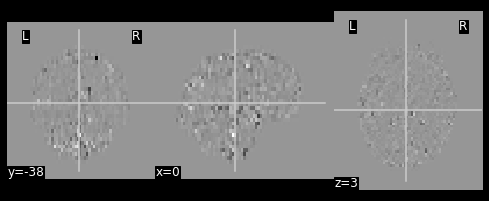

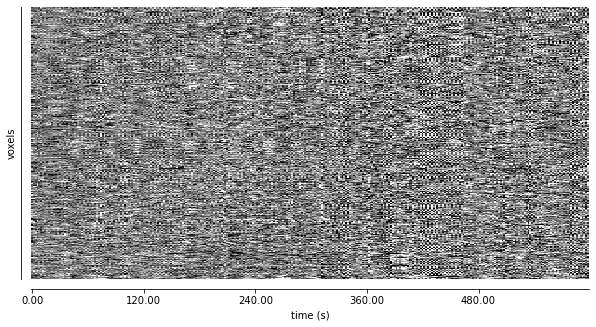

In [148]:
from nilearn.image.image import mean_img
plot_epi(mean_img(res_denoise.outputs.out_res), cmap="gray")

from nilearn.plotting import plot_carpet
display = plot_carpet(res_denoise.outputs.out_res, mask_img)
display.show()

Let's extract the "new" GS after the regression to compare it to the "pre"-denoised GS.

In [149]:
masked_data_after_regr = apply_mask(dir_func + 'denoised.nii.gz', dir_func + 'mcflirt_mean_brain_mask.nii.gz')
print(np.shape(masked_data_after_regr))
GS_after_regression = np.mean(masked_data_after_regr,axis=1)

(300, 33658)


We load the undenoised and denoised data to compare individual voxel timecourses. 
I selected the voxel [32,23,19] (located in the precuneus), but feel free to try out other voxel locations. You can use the interactive viewer to get their coordinates.

In [150]:
img_func_bef_denoising = nib.load(dir_func + 'mcflirt.nii.gz')
img_func_bef_denoising_data = img_func_bef_denoising.get_fdata()

In [151]:
img_func_denoised = nib.load(dir_func + 'denoised.nii.gz')
img_func_denoised_data = img_func_denoised.get_fdata()

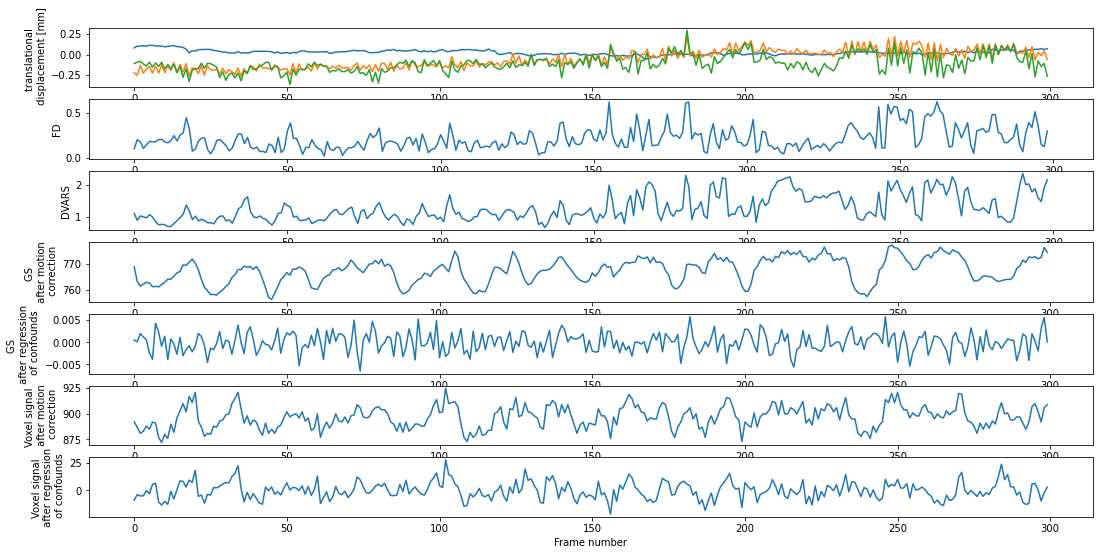

In [152]:
from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
fig = Figure(figsize=(18,9))
grid = GridSpec(7,1) 
ax = fig.add_subplot(grid[0,0])
ax.plot(rp[3])
ax.plot(rp[4])
ax.plot(rp[5])
ax.set_ylabel("translational \n displacement [mm]")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[1,0])
ax.plot(fd)
ax.set_ylabel("FD")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[2,0])
ax.plot(dvars)
ax.set_ylabel("DVARS")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[3,0])
ax.plot(GS)
ax.set_ylabel("GS \n after motion \n correction")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[4,0])
ax.plot(GS_after_regression)
ax.set_ylabel("GS \n after regression \n of confounds")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[5,0])
ax.plot(img_func_bef_denoising_data[32,23,19,:])
ax.set_ylabel("Voxel signal \n after motion \n correction")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[6,0])
ax.plot(img_func_denoised_data[32,23,19,:])
ax.set_ylabel("Voxel signal \n after regression \n of confounds")
ax.set_xlabel("Frame number")
fig

We see that after regressing the motion parameters and the global signal, our GS is shifted from around 700 to 0 (compare rows 4 & 5). This is because the denoised data are the **residuals** of the linear regression - and by definition centered around 0. Also, we see that the timeseries is actually *less* smooth - this is becaused we regressed the orange & green timeseries which contain much higher frequency noise.   
Also, from rows 6 & 7 we see that the individual voxel timeseries is changed rather subtly by the denoising procedure. Yet, as shown by the carpet plots, the global signal fluctuations (frame number ~ 250) are reduced. To further improve the denoising procedure, we could also include the average signal of the WM or CSF, or temporal derivatives of motion parameters.  
##### How to evaluate the denoising performance?
This is a very difficult question. For task-based fMRI, one could think of a sanity check (e.g. reliability of model parameters across runs, model performance in general) - but as you explicitely model the activity based on external cue, you are usually on the safe side including the main motion parameters. For resting state fMRI, some hints are given [here](https://experiments.springernature.com/articles/10.1038/s41596-018-0065-y): it is recommended to check the motion - functional connectivity correlation (less is better) and the distance-dependence of the FC (less is better). 

 <font color='grey'> 
Let's take a closer look to better understand the denoising outputs. First we plot the pre-and post denoising data for our favorite voxel. We see that they are still highly correlated (which we would expect given the plots above).  

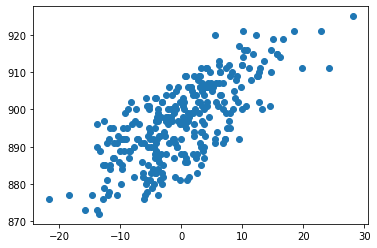

In [154]:
plt.scatter(img_func_denoised_data[32,23,19, :], img_func_bef_denoising_data[32,23,19, :])

The correlation of the timeseries before denoising and the global signal is also very high, indicating a high level of noise.

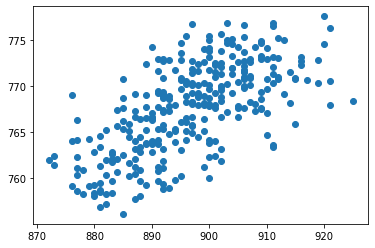

In [155]:
plt.scatter(img_func_bef_denoising_data[32,23,19, :],GS)

#### Exercise 6
What do you expect (in terms of correlation) if you plot the denoised voxel data against the GS? Please create the plot and explain to each other.

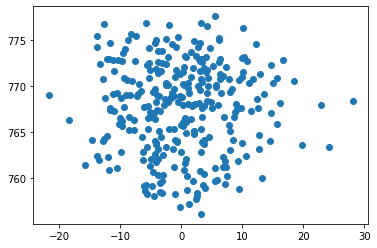

In [156]:
plt.scatter(img_func_denoised_data[32,23,19, :],GS)

## 5. Temporal filtering
Our fMRI data still contains periodic components which are more related to noise than to signal (e.g. scanner drifts). Temporal filtering aims to remove such frequencies which are not of interest.  
In task-based fMRI, the frequency of interest depends on your design, if e.g. a stimulus is shown every 5 seconds, the frequency of interest would be 0.2 Hz.  
In resting state fMRI, we are interested in low-frequency oscillations (i.e. from 0.01 to 0.1 Hz). Frequencies lower than that are often related to scanner drift or coil interference, while higher frequencies might be due to physiological noise (respiration at 0.3 Hz, or heart beat at around 1 Hz). 
While high-pass filtering is frequently used to remove low-frequency drifts, low-pass or band-pass filtering is more [controversial](https://en.wikibooks.org/wiki/Neuroimaging_Data_Processing/Temporal_Filtering) and sometimes [not recommended](https://neurostars.org/t/bandpass-filtering-different-outputs-from-fsl-and-nipype-custom-function/824).  

Temporal filtering can be achieved with different methods, mainly:
1. directly apply a gaussian filter to the fMRI data (as implemented in FSL which we use here)
2. include regressors for signal drifts in the first-level model (discrete cosine set / linear trends) 

Here, we use the fsl-interface `TemporalFilter` to do high-pass filtering to our denoised data.     

First, we need to specifiy the parameter sigma which corresponds to the width of the gaussian filter. Sigma is calculated as a function of the frequency cutoff and the TR. For more information on the gaussian filter, see [here](https://lukas-snoek.com/NI-edu/fMRI-introduction/week_4/temporal_preprocessing.html#high-pass-filtering-of-fmri-data-option-1).

In [42]:
TR = 2
HP_freq = 0.01
sigma_high = 1 / (2 * TR * HP_freq)

Now, let's run the filtering.

In [43]:
# Perform high-pass filtering to eliminate low-frequency drifts

highpass_filter = Node(fsl.TemporalFilter(out_file = dir_func + 'highpass.nii.gz'), name='highpass_filter')
highpass_filter.inputs.highpass_sigma = sigma_high
highpass_filter.inputs.in_file = dir_func + 'denoised.nii.gz'
hp_res = highpass_filter.run()

220719-10:50:14,69 nipype.workflow INFO:
	 [Node] Setting-up "highpass_filter" in "/tmp/tmprtrywt03/highpass_filter".
220719-10:50:14,79 nipype.workflow INFO:
	 [Node] Running "highpass_filter" ("nipype.interfaces.fsl.maths.TemporalFilter"), a CommandLine Interface with command:
fslmaths /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/denoised.nii.gz -bptf 25.000000 -1.000000 /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/highpass.nii.gz
220719-10:50:39,704 nipype.workflow INFO:
	 [Node] Finished "highpass_filter".


Let's now compare the signal of a given voxel before denoising, after denoising and after highpass filtering. 

In [44]:
img_func_bef_denoising = nib.load(dir_func + 'mcflirt.nii.gz')
img_func_bef_denoising_data = img_func_bef_denoising.get_fdata()
img_func_denoised = nib.load(dir_func + 'denoised.nii.gz')
img_func_denoised_data = img_func_denoised.get_fdata()
img_func_hp = nib.load(dir_func + 'highpass.nii.gz')
img_func_hp_data = img_func_hp.get_fdata()

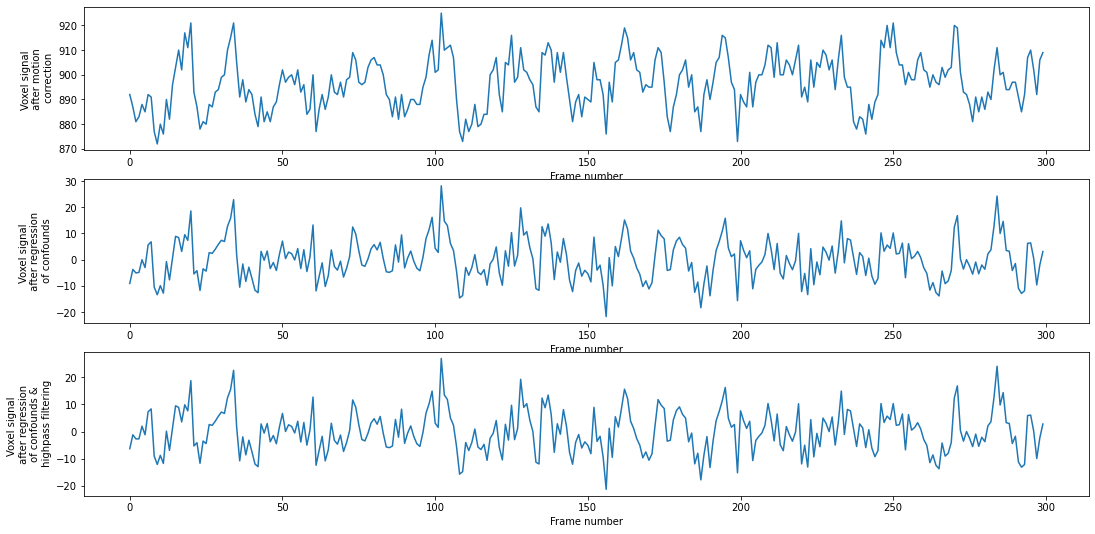

In [45]:
# Plot each signal in a separate subplot

from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
fig = Figure(figsize=(18,9))
grid = GridSpec(3,1) 
ax = fig.add_subplot(grid[0,0])
ax.plot(img_func_bef_denoising_data[32,23,19, :])
ax.set_ylabel("Voxel signal \n after motion \n correction")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[1,0])
ax.plot(img_func_denoised_data[32,23,19, :])
ax.set_ylabel("Voxel signal \n after regression \n of confounds")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[2,0])
ax.plot(img_func_hp_data[32,23,19, :])
ax.set_ylabel("Voxel signal \n after regression \n of confounds & \n highpass filtering")
ax.set_xlabel("Frame number")
fig

We see only little difference between the denoised and highpass-filtered time series. This is because much of the low-frequency drift was already removed in the regression step. Yet, there are small differences, e.g. for the first volumes.
We can also overlay the signals before and after highpass filtering to see the subtle differences.

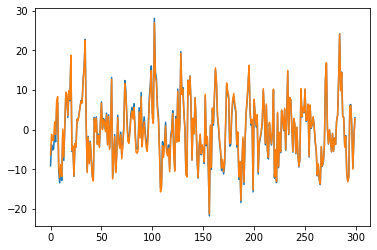

In [46]:
# Overlay signals before and after highpass filtering
plt.plot(img_func_denoised_data[32,23,19, :])
plt.plot(img_func_hp_data[32,23,19, :])

#### Exercise
Run the high-pass filter on the motion corrected data before denoising! Overlay the signal before and after high-pass filtering (note: different scaling of the data requires normalization)!  

220719-10:54:11,264 nipype.workflow INFO:
	 [Node] Setting-up "highpass_filter" in "/tmp/tmpsvx6rm0a/highpass_filter".
220719-10:54:11,269 nipype.workflow INFO:
	 [Node] Running "highpass_filter" ("nipype.interfaces.fsl.maths.TemporalFilter"), a CommandLine Interface with command:
fslmaths /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/mcflirt.nii.gz -bptf 25.000000 -1.000000 /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/highpass.nii.gz
220719-10:54:41,282 nipype.workflow INFO:
	 [Node] Finished "highpass_filter".


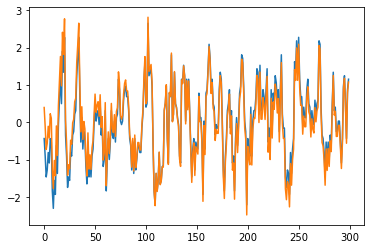

In [49]:
# Perform high-pass filtering to eliminate low-frequency drifts
highpass_filter = Node(fsl.TemporalFilter(out_file = dir_func + 'highpass.nii.gz'), name='highpass_filter')
highpass_filter.inputs.highpass_sigma = sigma_high
highpass_filter.inputs.in_file = dir_func + 'mcflirt.nii.gz'
hp_res = highpass_filter.run()

img_func_hp = nib.load(dir_func + 'highpass.nii.gz')
img_func_hp_data = img_func_hp.get_fdata()

plt.plot(scipy.stats.zscore(img_func_bef_denoising_data[32,23,19, :]))
plt.plot(scipy.stats.zscore(img_func_hp_data[32,23,19, :]))

## 6. Smoothing
Spatially smoothing your fMRI has advantages for detecting differences in group-analysis: it improves the signal-to-noise ratio and accounts for local activation differences between individual participants. Usually, you use a Gaussian filter with a kernel size around 4-10 mm. Ideally, filter width matches the expected signal width (fMRI data is inherently smooth because of co-activation and hemodynamic convolution). See also this [page](https://support.brainvoyager.com/brainvoyager/functional-analysis-preparation/29-pre-processing/86-spatial-smoothing) for more information.

In [62]:
# Import IsotropicSmooth from the FSL interface
from nipype.interfaces.fsl import IsotropicSmooth

# Define a node
smooth_node = Node(IsotropicSmooth(), name="smoothing")
smooth_node.inputs.in_file = dir_func + "highpass.nii.gz"
#smooth_node.inputs.in_file = dir_func + "mcflirt.nii.gz"
smooth_node.inputs.fwhm = 4
smooth_node.inputs.out_file = dir_func + "highpass_4mm.nii.gz"
smooth_res = smooth_node.run()

220719-11:06:10,661 nipype.workflow INFO:
	 [Node] Setting-up "smoothing" in "/tmp/tmp0iqu2mt3/smoothing".
220719-11:06:10,665 nipype.workflow INFO:
	 [Node] Running "smoothing" ("nipype.interfaces.fsl.maths.IsotropicSmooth"), a CommandLine Interface with command:
fslmaths /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/highpass.nii.gz -s 1.69864 /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/highpass_4mm.nii.gz
220719-11:06:22,314 nipype.workflow INFO:
	 [Node] Finished "smoothing".


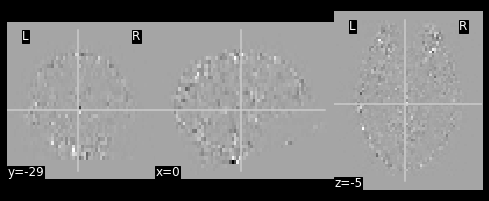

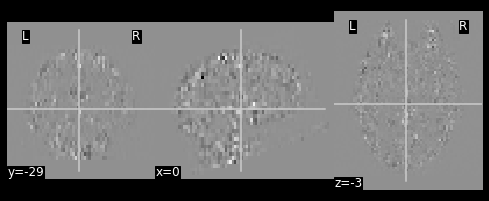

In [65]:
from nilearn.plotting import plot_epi
from nilearn.image.image import mean_img

plot_epi(mean_img(smooth_node.inputs.in_file), cmap="gray")
plot_epi(mean_img(smooth_node.inputs.out_file),  cmap="gray")

#### Exercise 4
As the denoised image is already demeaned, this plot has a low contrast and therefore doesn't show the smoothing effect very well. For a better comparison, use a non-denoised image (e.g. data after motion correction) as input (see commented line above). Try smoothing with 6mm and 10mm kernels and compare the results visually.

## 7. Denoising within the first-level model

The previous steps to remove noise can also be incorporated directly in a linear model of the fMRI timeseries (first-level model). We already performed a nuisance regression [above](#4.2-Nuisance-regression) using FSL. This can also be implemented in nilearn. For example, noise regressors can be added to the design matrix of the first-level model and arguments can be used to specify high-pass filtering and smoothing options.

In task-based fMRI, the first-level model is used to investigate effects of interest as designed by the task, e.g. task parameters as beta values ([here](
https://nilearn.github.io/stable/auto_examples/plot_single_subject_single_run.html#sphx-glr-auto-examples-plot-single-subject-single-run-py) an example. With our resting-state dataset here, we can use nilearn to remove noise from the data via nuisance regression and use the residuals for further analyses. Below we run a first-level model with noise regressors and extract the residuals and explained variance.

/tmp/ipykernel_66/4293259174.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  realign_param = pd.read_csv(dir_func + "mcflirt.nii.gz.par", header=None, sep='  ')


Plotting the design matrix


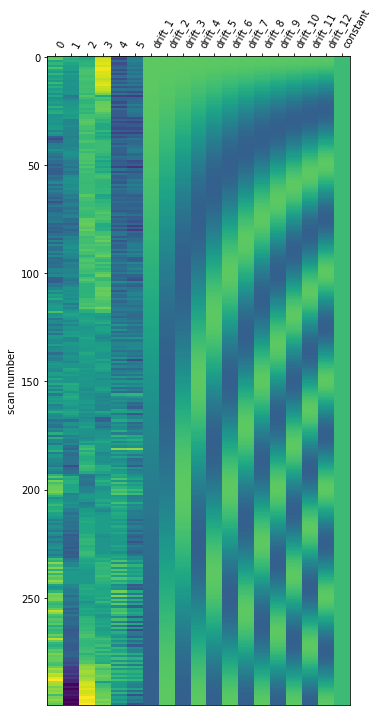

/home/jovyan/.local/lib/python3.9/site-packages/nilearn/glm/regression.py:42: FutureWarning: 'resid' has been deprecated in version 0.7.0 and will be removed in version 0.9.0. Please use 'residuals' instead.
  warnings.warn(category=FutureWarning,


Across the brain, the regressors explain 43.0 % of the variance of the data.


In [90]:
import nilearn
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

# set arguments of function FirstLevelModel, including high-pass filtering and smoothing
glm = FirstLevelModel(
    t_r = 2,
    hrf_model = 'glover',
    drift_model = 'cosine',
    high_pass = 0.01,
    smoothing_fwhm = 4,
    minimize_memory = False,
    n_jobs = -1)

# create design matrix which includes the realignment parameters
realign_param = pd.read_csv(dir_func + "mcflirt.nii.gz.par", header=None, sep='  ')
design_matrix = make_first_level_design_matrix(frame_times = np.arange(img_func.shape[3])*2,
                                    add_regs = realign_param)

# run the glm
glm.fit(run_imgs = dir_func + 'mcflirt.nii.gz',
        events = None,
        confounds = None,
        design_matrices = design_matrix)

print("Plotting the design matrix")
plot_design_matrix(glm.design_matrices_[0])
plt.show()

# get the denoised image = residuals
img_denoised = glm.residuals[0]

# get the explained variance
img_rsquare = glm.r_square[0]
explained_variance = nilearn.masking.apply_mask(img_rsquare, mask_img).mean()
print(f'Across the brain, the regressors explain {explained_variance.round(2) * 100} % of the variance of the data.')

## Standardized preprocessing pipelines: fMRIPrep and MRIQC

As mentioned at the beginning of this notebook, fMRI preprocessing can be performed almost automatically by standardized pipelines such as [fMRIPrep](https://fmriprep.org/en/stable/). fMRIPrep combines the nipype interfaces we used before with preprocessing functions of various fMRI software packages (e.g. FSL, SPM, Freesurfer). Here's an overview of fMRIPrep's workflow:

![picture](https://github.com/oesteban/fmriprep/raw/f4c7a9804be26c912b24ef4dccba54bdd72fa1fd/docs/_static/fmriprep-21.0.0.svg)

fMRIPrep makes use of a standardized data structure called [BIDS](https://bids.neuroimaging.io/). Once the data (e.g. MRI images, behavioral (event) files) is organized in BIDS, fMRIPrep can be easily executed by a command. In the easiest case (without specifying further parameters) a command would look like:  
`fmriprep data/bids_root/ out/ participant -w work/`

In addition to the preprocessed brain images and estimated confounds, fMRIPrep also generates a report with information on the individual steps including e.g. registration and motion. An example report can be found [here](https://fmriprep.org/en/stable/_static/SampleReport/sample_report.html).


More quality checks on both functional and structural MRI images can be performed with [MRIQC](https://mriqc.readthedocs.io/en/stable/). MRIQC computes a variety of quality metrics, e.g. motion, signal-to-noise ratio, image artifacts. 

![picture](https://mriqc.readthedocs.io/en/stable/_images/OHBM2017-poster.png)

Similar to fMRIPrep, MRIQC makes use of the BIDS format and can be executed by a command - in the easiest case:  
`mriqc bids-root/ output-folder/ participant`

[Here](https://mriqc.readthedocs.io/en/stable/reports.html)'s a short demonstration of MRIQC and [example report](http://web.stanford.edu/group/poldracklab/mriqc/reports/sub-50013_task-rest_bold.html).

# Thank you for participating in this workshop!